# Designing a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense.

In [1]:
# All necessary imports
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

Define function to load the data

In [2]:
# Load data
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

Follow instructions under [Data Section](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3#ii-data) to download the datasets.  

We will be using the clean validation data (valid.h5) from cl folder to design the defense and clean test data (test.h5 from cl folder) and  sunglasses poisoned test data (bd_test.h5 from bd folder) to evaluate the models.

In [3]:
## To-do ##
# After downloading the datasets, provide corresponding filepaths below 

clean_data_valid_filename = "./data/cl/valid.h5"

clean_data_test_filename = "./data/cl/test.h5"
poisoned_data_test_filename = "./data/bd/bd_test.h5"

Read the data:

In [4]:
cl_x_valid, cl_y_valid = data_loader(clean_data_valid_filename)

cl_x_test, cl_y_test = data_loader(clean_data_test_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_test_filename)

Visualizing the clean test data

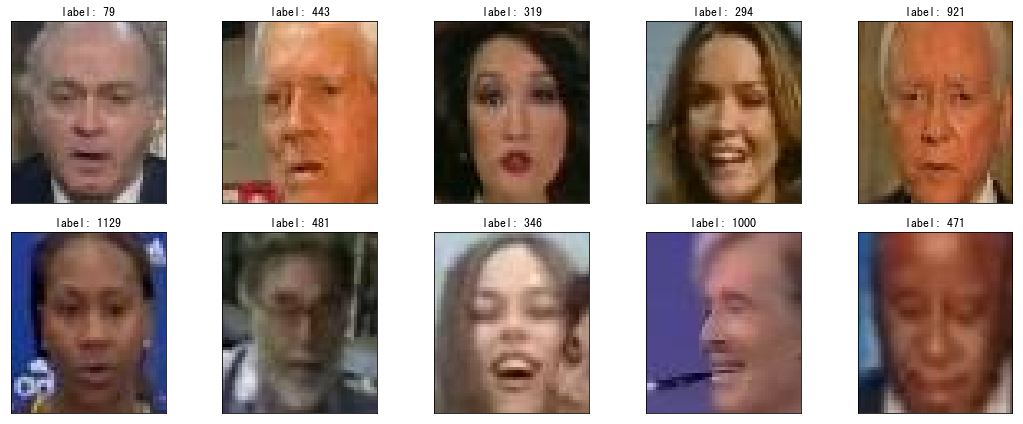

In [5]:
# Plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(cl_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(cl_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Visualizing the sunglasses poisioned test data

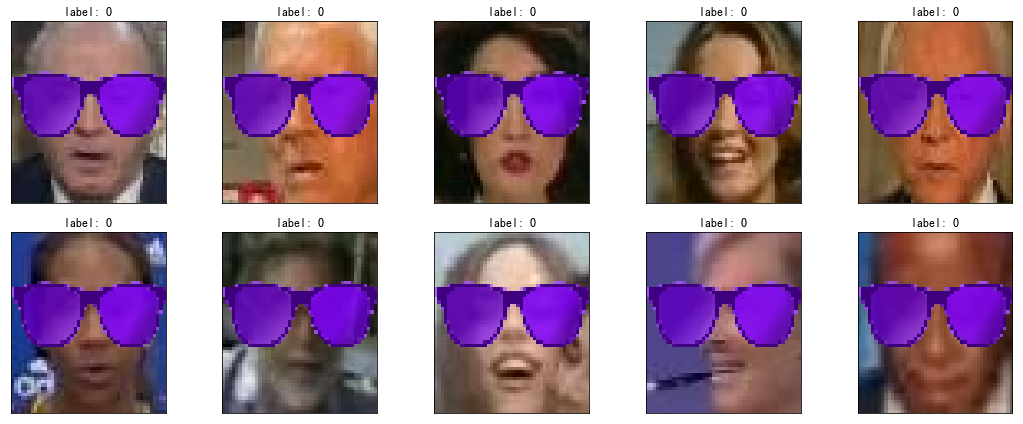

In [6]:
# Plot some images from the validation set (see https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/)
num = 10
np.random.seed(45)
randIdx = [np.random.randint(10000) for i in range(num)]
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(bd_x_test[randIdx[i]].astype('uint8'))
    ax.set_title('label: {:.0f}'.format(bd_y_test[randIdx[i]]))
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

Load the backdoored model.

The backdoor model and its weights can be found [here](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/lab3/models) 

In [7]:
## To-do ##

# First create clones of the original badnet model (by providing the model filepath below)
# The result of repairing B_clone will be B_prime

B = keras.models.load_model("./model/bd_net.h5")
B.load_weights("./model/bd_weights.h5")

B_clone = keras.models.load_model("./model/bd_net.h5")
B_clone.load_weights("./model/bd_weights.h5")

Output of the original badnet accuracy on the validation data:

In [8]:
# Get the original badnet model's (B) accuracy on the validation data
cl_label_p = np.argmax(B(cl_x_valid), axis=1)
clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_valid)) * 100

print("Clean validation accuracy before pruning {0:3.6f}".format(clean_accuracy))

K.clear_session()

Clean validation accuracy before pruning 98.649000


In [9]:
print(B.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Write code to implement pruning defense 

In [10]:
## To-do ##

# Redefine model to output right after the last pooling layer ("pool_3")
intermediate_model = Model(inputs=B.inputs, outputs=B.get_layer('pool_3').output)

# Get feature map for last pooling layer ("pool_3") using the clean validation data and intermediate_model
feature_maps_cl = intermediate_model(cl_x_valid)

# Get average activation value of each channel in last pooling layer ("pool_3")
averageActivationsCl = np.mean(feature_maps_cl, 0)

# Store the indices of average activation values (averageActivationsCl) in increasing order
avgActByCh = np.mean(np.abs(feature_maps_cl), axis = (0, 1, 2))
idxToPrune = np.argsort(np.abs(avgActByCh))

# Get the conv_4 layer weights and biases from the original network that will be used for prunning
# Hint: Use the get_weights() method (https://stackoverflow.com/questions/43715047/how-do-i-get-the-weights-of-a-layer-in-keras)
lastConvLayerWeights = B_clone.layers[5].get_weights()[0]
lastConvLayerBiases  = B_clone.layers[5].get_weights()[1]

flag = [0, 0, 0]

for chIdx in idxToPrune:

  # Prune one channel at a time
  # Hint: Replace all values in channel 'chIdx' of lastConvLayerWeights and lastConvLayerBiases with 0 
  lastConvLayerWeights[:,:,:,chIdx] = 0
  lastConvLayerBiases[chIdx] = 0

  # Update weights and biases of B_clone
  # Hint: Use the set_weights() method 
  B_clone.layers[5].set_weights([lastConvLayerWeights,lastConvLayerBiases])

  # Evaluate the updated model's (B_clone) clean validation accuracy
  cl_label_p_valid = np.argmax(B_clone(cl_x_valid), axis=1)
  clean_accuracy_valid = np.mean(np.equal(cl_label_p_valid, cl_y_valid)) * 100

  # If drop in clean_accuracy_valid is just greater (or equal to) than the desired threshold compared to clean_accuracy, then save B_clone as B_prime and break
  if (clean_accuracy - clean_accuracy_valid)/clean_accuracy *100 >= 2 and not flag[0]:
        B_clone.save('./fixed_models/bd_2.h5')
        B_clone.save_weights('./fixed_models/bd_2_weights.h5')
        print("Model has been saved as bd_2.h5 and bd_2_weights.h5")
        flag[0] = 1
  if (clean_accuracy - clean_accuracy_valid)/clean_accuracy *100 >= 4 and not flag[1]:
        B_clone.save('./fixed_models/bd_4.h5')
        B_clone.save_weights('./fixed_models/bd_4_weights.h5')
        print("Model has been saved as bd_4.h5 and bd_4_weights.h5")
        flag[1] = 1
  if (clean_accuracy - clean_accuracy_valid)/clean_accuracy *100 >= 10 and not flag[2]:
        B_clone.save('./fixed_models/bd_10.h5')
        B_clone.save_weights('./fixed_models/bd_10_weights.h5')
        print("Model has been saved as bd_10.h5 and bd_10_weights.h5")
        flag[2] = 1
        break


Model has been saved as bd_2.h5 and bd_2_weights.h5
Model has been saved as bd_4.h5 and bd_4_weights.h5
Model has been saved as bd_10.h5 and bd_10_weights.h5


Now we need to combine the models into a repaired goodnet G  that outputs the correct class if the test input is clean and class N+1 if the input is backdoored. One way to do it is to "subclass" the models in Keras: 

In [11]:
#https://stackoverflow.com/questions/64983112/keras-vertical-ensemble-model-with-condition-in-between
class G(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

    # For small amount of inputs that fit in one batch, directly using call() is recommended for faster execution, 
    # e.g., model(x), or model(x, training=False) is faster then model.predict(x) and do not result in
    # memory leaks (see for more details https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict)
    def call(self,data):
        y = np.argmax(self.B(data), axis=1)
        y_prime = np.argmax(self.B_prime(data), axis=1)
        tmpRes = np.array([y[i] if y[i] == y_prime[i] else 1283 for i in range(y.shape[0])])
        res = np.zeros((y.shape[0],1284))
        res[np.arange(tmpRes.size),tmpRes] = 1
        return res

However, Keras prevents from saving this kind of subclassed model as HDF5 file since it is not serializable. However, we still can use this architecture for model evaluation.

Load the saved B_prime model

In [12]:
## To-do ##
# Provide B_prime model filepath below

# 2%
B_prime_2 = keras.models.load_model("./fixed_models/bd_2.h5")
B_prime_2.load_weights("./fixed_models/bd_2_weights.h5")

# 4%
B_prime_4 = keras.models.load_model("./fixed_models/bd_4.h5")
B_prime_4.load_weights("./fixed_models/bd_4_weights.h5")

# 10%
B_prime_10 = keras.models.load_model("./fixed_models/bd_10.h5")
B_prime_10.load_weights("./fixed_models/bd_10_weights.h5")

Check performance of the repaired model on the test data:

In [13]:
# 2%
cl_label_p = np.argmax(B_prime_2.predict(cl_x_test), axis=1)
clean_accuracy_B_prime_2 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime_2:', clean_accuracy_B_prime_2)

bd_label_p = np.argmax(B_prime_2.predict(bd_x_test), axis=1)
asr_B_prime_2 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime_2:', asr_B_prime_2)
print("-----------------------------------------------------------")

# 4%
cl_label_p = np.argmax(B_prime_4.predict(cl_x_test), axis=1)
clean_accuracy_B_prime_4 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime_4:', clean_accuracy_B_prime_4)

bd_label_p = np.argmax(B_prime_4.predict(bd_x_test), axis=1)
asr_B_prime_4 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime_4:', asr_B_prime_4)
print("-----------------------------------------------------------")

# 10%
cl_label_p = np.argmax(B_prime_10.predict(cl_x_test), axis=1)
clean_accuracy_B_prime_10 = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B_prime_10:', clean_accuracy_B_prime_10)

bd_label_p = np.argmax(B_prime_10.predict(bd_x_test), axis=1)
asr_B_prime_10 = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B_prime_10:', asr_B_prime_10)

Clean Classification accuracy for B_prime_2: 95.90023382696803
Attack Success Rate for B_prime_2: 100.0
-----------------------------------------------------------
Clean Classification accuracy for B_prime_4: 92.29150428682775
Attack Success Rate for B_prime_4: 99.98441153546376
-----------------------------------------------------------
Clean Classification accuracy for B_prime_10: 84.54403741231489
Attack Success Rate for B_prime_10: 77.20966484801247


Check performance of the original model on the test data:

In [14]:
cl_label_p = np.argmax(B.predict(cl_x_test), axis=1)
clean_accuracy_B = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for B:', clean_accuracy_B)

bd_label_p = np.argmax(B.predict(bd_x_test), axis=1)
asr_B = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for B:', asr_B)

Clean Classification accuracy for B: 98.62042088854248
Attack Success Rate for B: 100.0


Create repaired network

In [15]:
# Repaired network repaired_net
# 2%
repaired_net_2 = G(B, B_prime_2)

# 4%
repaired_net_4 = G(B, B_prime_4)

# 10%
repaired_net_10 = G(B, B_prime_10)

Check the performance of the repaired_net on the test data

In [16]:
# 2%
cl_label_p = np.argmax(repaired_net_2(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for repaired_net_2:', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net_2(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for repaired_net_2:', asr_repaired_net)
print("-----------------------------------------------------------")

# 4%
cl_label_p = np.argmax(repaired_net_4(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for repaired_net_4:', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net_4(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for repaired_net_4:', asr_repaired_net)
print("-----------------------------------------------------------")

# 10%
cl_label_p = np.argmax(repaired_net_10(cl_x_test), axis=1)
clean_accuracy_repaired_net = np.mean(np.equal(cl_label_p, cl_y_test))*100
print('Clean Classification accuracy for repaired_net_10:', clean_accuracy_repaired_net)

bd_label_p = np.argmax(repaired_net_10(bd_x_test), axis=1)
asr_repaired_net = np.mean(np.equal(bd_label_p, bd_y_test))*100
print('Attack Success Rate for repaired_net_10:', asr_repaired_net)

Clean Classification accuracy for repaired_net_2: 95.74434918160561
Attack Success Rate for repaired_net_2: 100.0
-----------------------------------------------------------
Clean Classification accuracy for repaired_net_4: 92.1278254091972
Attack Success Rate for repaired_net_4: 99.98441153546376
-----------------------------------------------------------
Clean Classification accuracy for repaired_net_10: 84.3335931410756
Attack Success Rate for repaired_net_10: 77.20966484801247
